# Introduction

This is the analysis of gut intestinal stem cell data as presented in Böttcher et al. We use in total **75,012** cells from **14 samples** in **6 conditions** (2 replicates in each mutant, 3 replicates in each control and 1 sample FVR only controls):

* Control (whole crypt)
* Control (FVR enriched)
* Control (FVR only)
* Mutant (Fltp deficient, whole crypt)
* Mutant (Fltp deficient, FVR enriched)
* Control (High fat diet project)

In this notebook, data are not batch effect corrected.

We filtered cells by

* number of reads
* number of detected genes
* fraction of mitochondrial reads (< 10%) 


## Tasks in this notebook

In order to keep the notebook structure short and well-arranged, we have split the gut intestinal stem cell analysis into several parts:

1. Pre-processing and filtering
2. Preparation of Batch effect correction
3. Batch effect correction with adjusted ComBat 
4. Data analysis with Graph abstraction

This notebook covers **part 2**.

# Initialise scanpy


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import scanpy.api as sc
import matplotlib as mpl
import anndata as ann
#import matplotlib.pyplot as plt
from matplotlib import rcParams

import seaborn as sns
import scipy as sci
import os

sc.settings.verbosity = 3                # amount of output
sc.settings.set_figure_params(dpi=150, color_map='RdYlBu_r')
sc.logging.print_version_and_date()

Running Scanpy 1.3.1 on 2021-01-22 13:59.


## Load extensions

In [2]:
%run '~/Documents/Python/maren_codes/genes_to_xls.py'

# Load data

In [3]:
adata = sc.read('./../data/new_filter_all.h5')

In [4]:
adata_cd = sc.read('./../data/control_only_new_filter_all_vers_1_4.h5')

In [5]:
adata

AnnData object with n_obs × n_vars = 59036 × 16413 
    obs: 'n_counts', 'sample', 'percent_mito', 'percent_ribo', 'n_genes'
    var: 'n_cells', 'mean', 'frac_zeros'

In [6]:
adata_cd

AnnData object with n_obs × n_vars = 15976 × 14965 
    obs: 'percent_mito', 'percent_ribo', 'n_counts', 'n_genes', 'sample'
    var: 'mean-CD_1', 'frac_zeros-CD_1', 'mean-CD_2', 'frac_zeros-CD_2', 'mean-CD_3', 'frac_zeros-CD_3', 'n_cells', 'mean', 'frac_zeros'

Data merging is not straightforward, unfortunately. We create new `anndata` objects with less variables to alleviate the merging.

In [7]:
adat = ann.AnnData(X=adata.X)
adat.var_names = adata.var_names
adat.obs_names = adata.obs_names
adat.obs['sample']=adata.obs['sample']
adat.obs['percent_mito']=adata.obs['percent_mito']
adat.obs['percent_ribo']=adata.obs['percent_ribo']
adat.obs['n_counts']=adata.obs['n_counts']
adat.obs['n_genes']=adata.obs['n_genes']

In [8]:
adat_cd = ann.AnnData(X=adata_cd.X)
adat_cd.var_names = adata_cd.var_names
adat_cd.obs_names = adata_cd.obs_names
adat_cd.obs['sample']=adata_cd.obs['sample']
adat_cd.obs['percent_mito']=adata_cd.obs['percent_mito']
adat_cd.obs['percent_ribo']=adata_cd.obs['percent_ribo']
adat_cd.obs['n_counts']=adata_cd.obs['n_counts']
adat_cd.obs['n_genes']=adata_cd.obs['n_genes']

In [9]:
adat_cd.obs_names_make_unique()
adat_cd.var_names_make_unique()
adat.obs_names_make_unique()
adat.var_names_make_unique()

In [10]:
adata_all = adat.concatenate(adat_cd,join='inner', index_unique='-')

In [11]:
adata_all

AnnData object with n_obs × n_vars = 75012 × 14941 
    obs: 'sample', 'percent_mito', 'percent_ribo', 'n_counts', 'n_genes', 'batch'

In [12]:
del adata
del adata_cd
del adat
del adat_cd

# Doublet score

We compute a doublet score on the raw count data for each sample using **Scrublet**. We will remove all cells with a doublet score *greater than 0.4*. The tool itself recommends to use a threshold of *0.25*, but we choose a more conservative strategy. 

In [14]:
!pip install scrublet

    100% |████████████████████████████████| 655kB 5.6MB/s ta 0:00:01
    100% |████████████████████████████████| 29.8MB 877kB/s eta 0:00:01
    100% |████████████████████████████████| 2.2MB 6.7MB/s eta 0:00:01
    100% |████████████████████████████████| 3.3MB 2.2MB/s ta 0:00:011    89% |████████████████████████████▊   | 3.0MB 6.7MB/s eta 0:00:01
    100% |████████████████████████████████| 153kB 16.4MB/s ta 0:00:01
    100% |████████████████████████████████| 4.3MB 4.9MB/s eta 0:00:01
  Stored in directory: /Users/Maren.Buettner/Library/Caches/pip/wheels/3a/c5/59/cce7e67b52c8e987389e53f917b6bb2a9d904a03246fadcb1e
  Stored in directory: /Users/Maren.Buettner/Library/Caches/pip/wheels/59/95/cc/5a9c2cd844519053210dc9566ba656a7fbec625b3abf59fb74
Successfully built annoy scikit-image
You are using pip version 19.0.1, however version 20.3.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [15]:
import scrublet as scr
import scipy.io
import time

In [16]:
adata_all.obs['doublet_score']= np.zeros(adata_all.shape[0])
adata_all.obs['doublet'] = np.zeros(adata_all.shape[0])

In [17]:
adata_all.obs['sample'] = adata_all.obs['sample'].astype('category')

In [18]:
# filtering/preprocessing parameters:
min_counts = 2
min_cells = 3
vscore_percentile = 85
n_pc = 50

# doublet detector parameters:
expected_doublet_rate = 0.02 
sim_doublet_ratio = 3
n_neighbors = 15

for batch in enumerate(adata_all.obs['sample'].cat.categories):
    t0 = time.time()
    idx = np.flatnonzero(adata_all.obs['sample']==batch[1])
    scrub = scr.Scrublet(counts_matrix = adata_all[idx,:].X,  
                     n_neighbors = n_neighbors,
                     sim_doublet_ratio = sim_doublet_ratio,
                     expected_doublet_rate = expected_doublet_rate)
    doublet_scores, predicted_doublets = scrub.scrub_doublets( 
                    min_counts = min_counts, 
                    min_cells = min_cells, 
                    n_prin_comps = n_pc,
                    use_approx_neighbors = True, 
                    get_doublet_neighbor_parents = False)
    adata_all.obs['doublet_score'].iloc[idx] = doublet_scores
    adata_all.obs['doublet'].iloc[idx] = predicted_doublets
    t1 = time.time()
    print('Elapsed time: {:.1f} seconds'.format(t1 - t0))


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.14
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 16.8%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 6.7%
Elapsed time: 10.8 seconds
Elapsed time: 11.7 seconds


/Users/Maren.Buettner/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.15
Detected doublet rate = 1.2%
Estimated detectable doublet fraction = 12.1%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 9.7%
Elapsed time: 8.9 seconds
Elapsed time: 9.8 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.14
Detected doublet rate = 0.8%
Estimated detectable doublet fraction = 15.2%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 5.2%
Elapsed time: 9.4 seconds
Elapsed time: 10.2 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.14
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 24.7%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 4.5%
Elapsed ti

# Log-scale.

In [19]:
sc.pp.log1p(adata_all)

# Plot QC metrics

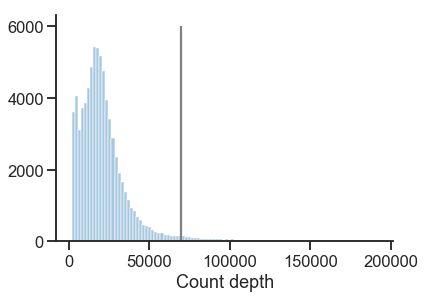

In [20]:
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("talk")
fig = sns.distplot(adata_all.obs['n_counts'], bins=100, kde=False)
pl.vlines(70000, 0, 6000, 'grey')
sns.despine()
fig.set(xlabel='Count depth')
pl.savefig('./../figures/count_depth.pdf', 
          transparent=True, orientation='landscape', bbox_inches='tight')

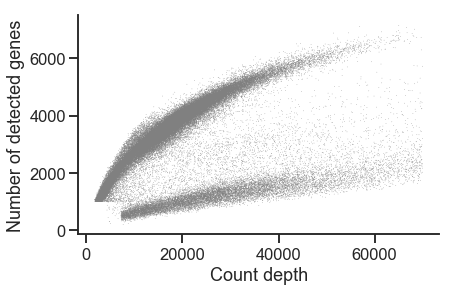

In [21]:
fig= sc.pl.scatter(adata_all[adata_all.obs['n_counts']<70000,:], 
                   x='n_counts', y='n_genes', show=False)
fig.set(xlabel='Count depth', ylabel='Number of detected genes')
sns.despine()
pl.savefig('./../figures/genes_counts_scatter.pdf', 
          transparent=True, orientation='landscape', bbox_inches='tight')

# Dimension reduction

In [23]:
sc.tl.pca(adata_all)

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.


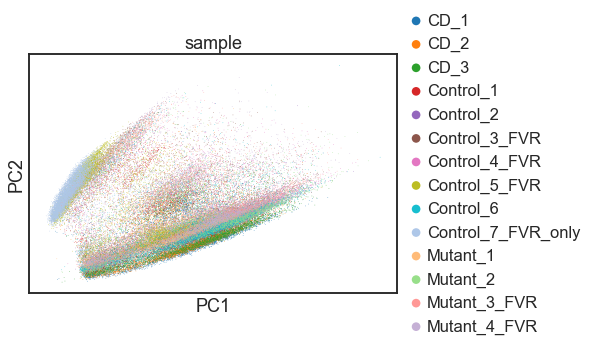

In [24]:
sc.pl.pca(adata_all, color=['sample'])


In [25]:
sc.tl.tsne(adata_all)

computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:13:04.32) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


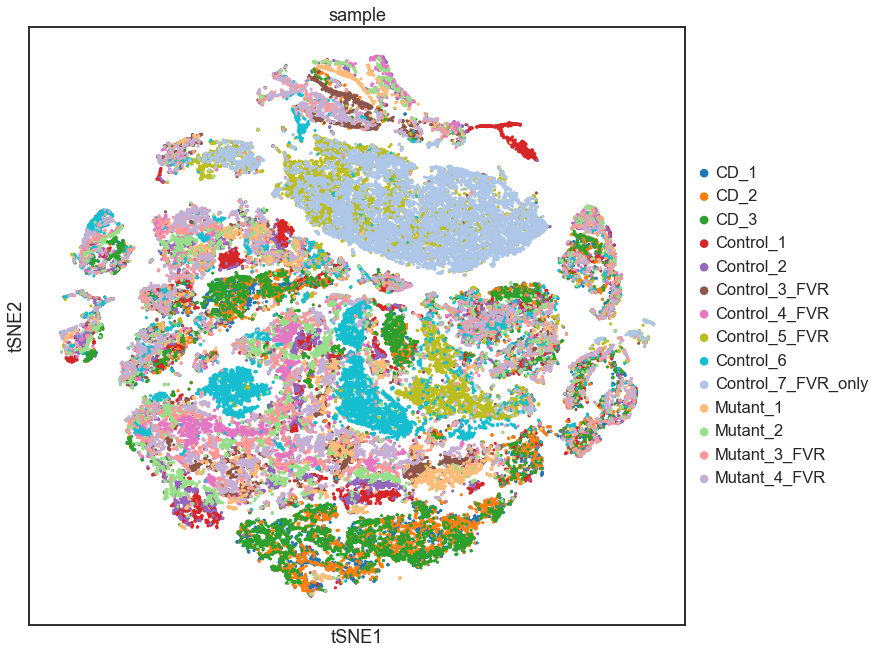

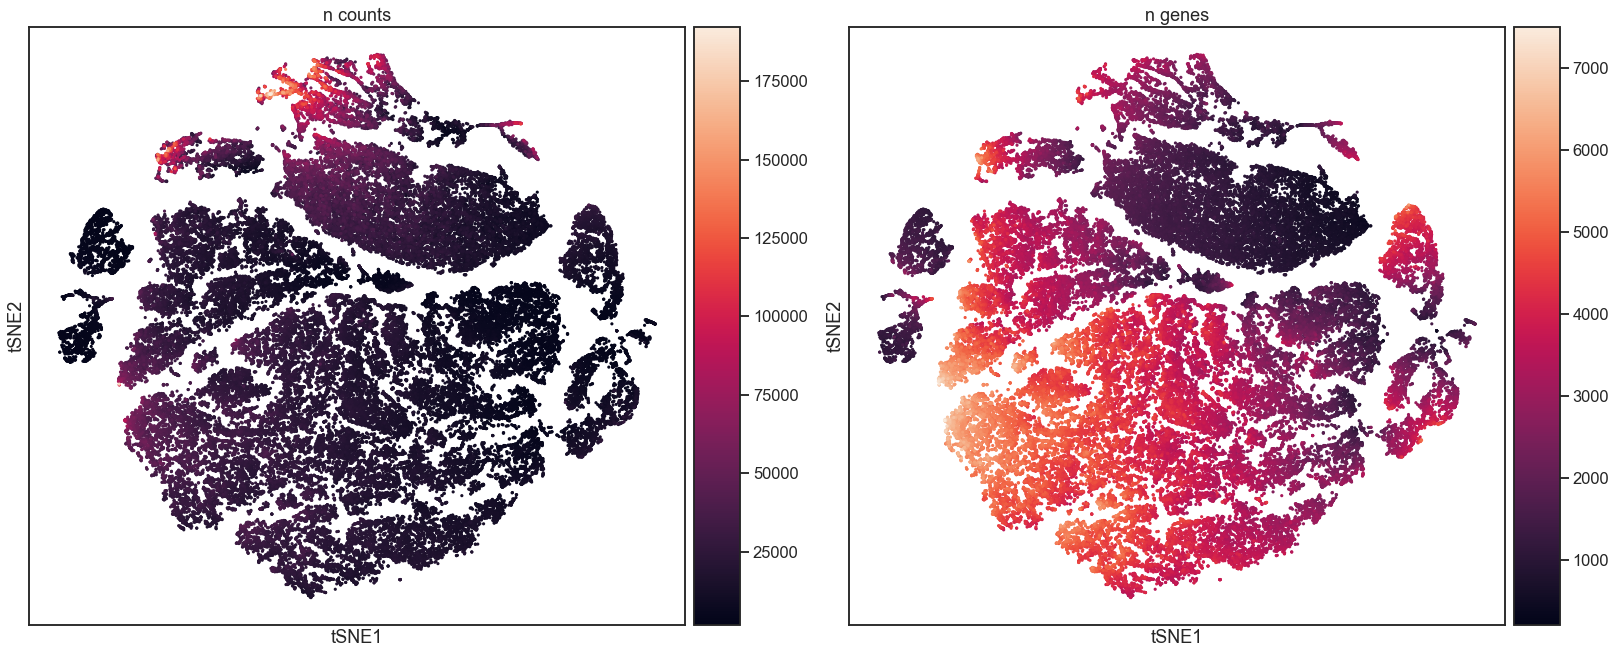

In [26]:
rcParams['figure.figsize']=(10,10)
sc.pl.tsne(adata_all, color=['sample'], size=40)
sc.pl.tsne(adata_all, color=['n_counts', 'n_genes'], size=40)

In [28]:
sc.pp.neighbors(adata_all)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:30.37) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


In [29]:
sc.tl.umap(adata_all)

computing UMAP
    finished (0:01:05.51) --> added
    'X_umap', UMAP coordinates (adata.obsm)


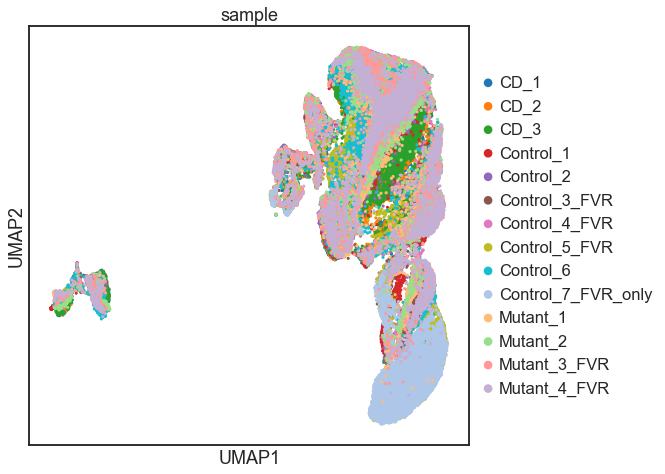

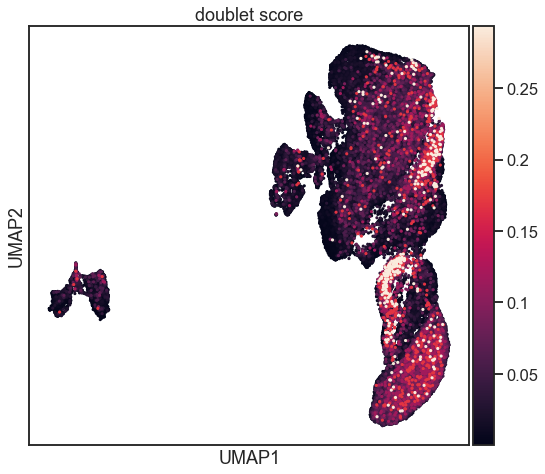

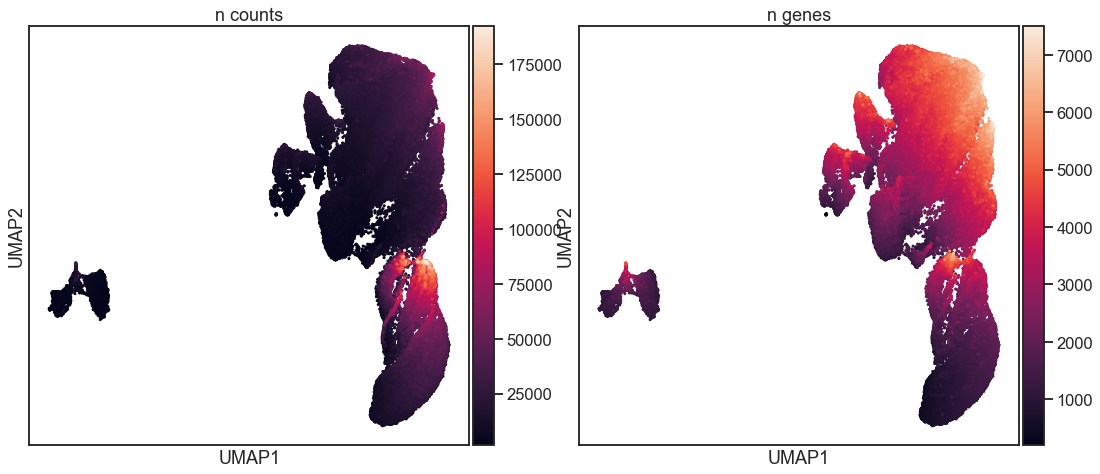

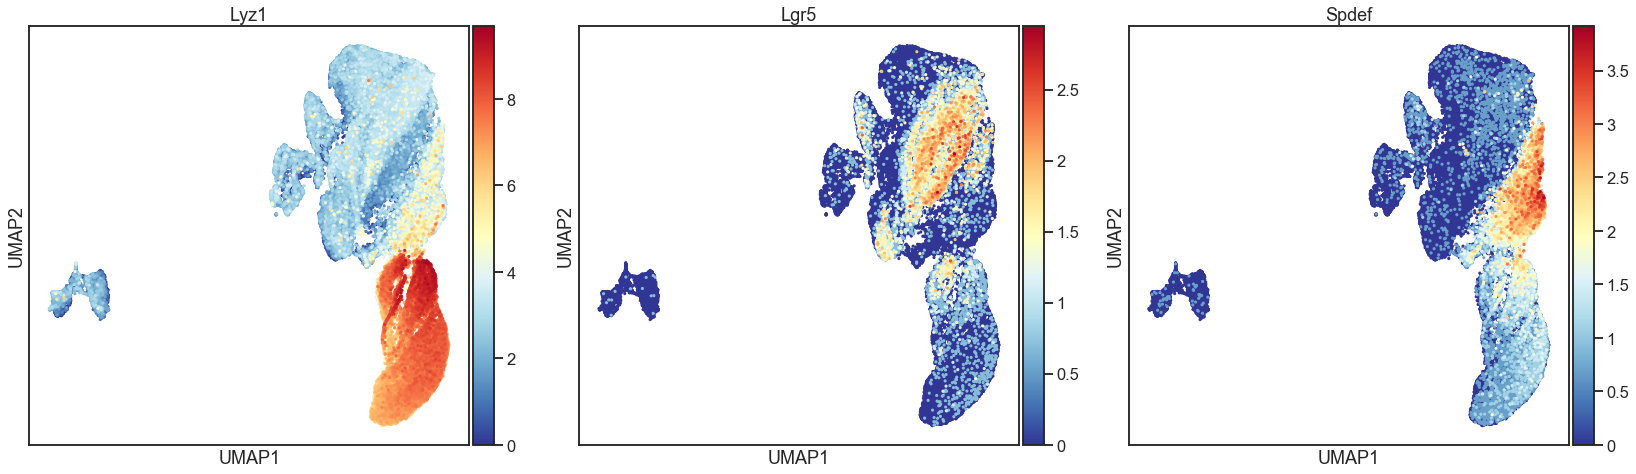

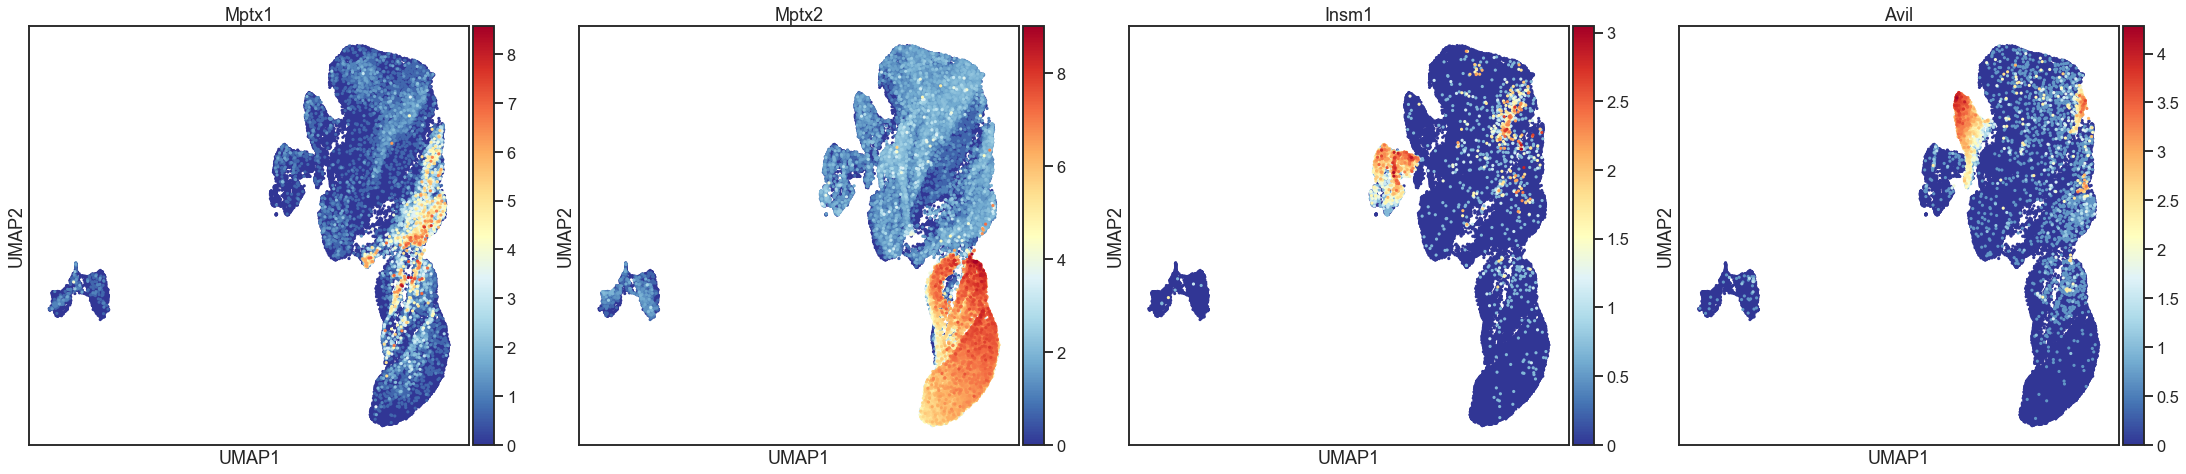

In [30]:
rcParams['figure.figsize']=(7,7)
sc.pl.umap(adata_all, color=['sample'], size=40)
sc.pl.umap(adata_all, color=['doublet_score'], size=40)
sc.pl.umap(adata_all, color=['n_counts', 'n_genes'], size=40)
sc.pl.umap(adata_all, color=['Lyz1', 'Lgr5', 'Spdef'], size=40, color_map='RdYlBu_r')
sc.pl.umap(adata_all, color=['Mptx1', 'Mptx2', "Insm1", 'Avil'], size=40,color_map='RdYlBu_r')

In [31]:
sc.write(adata=adata_all, filename='./../data/gut_AB_AL_all.h5ad')

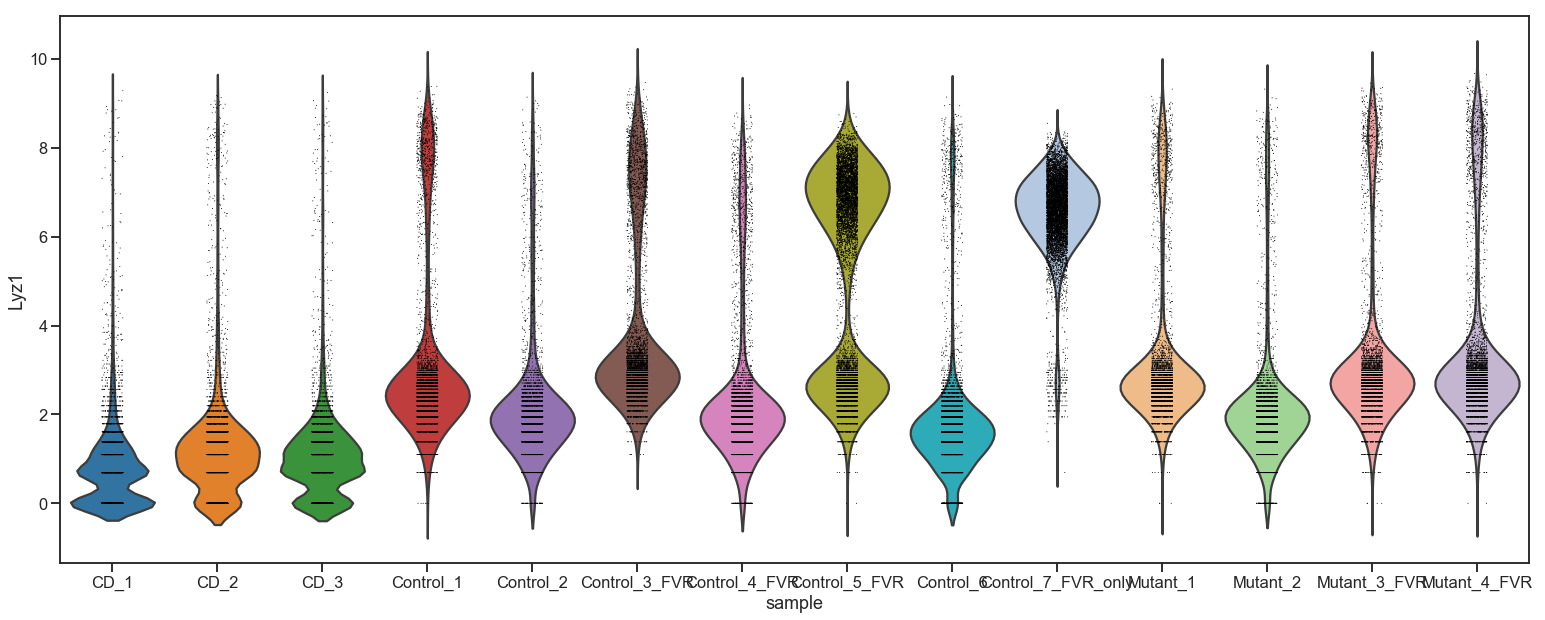

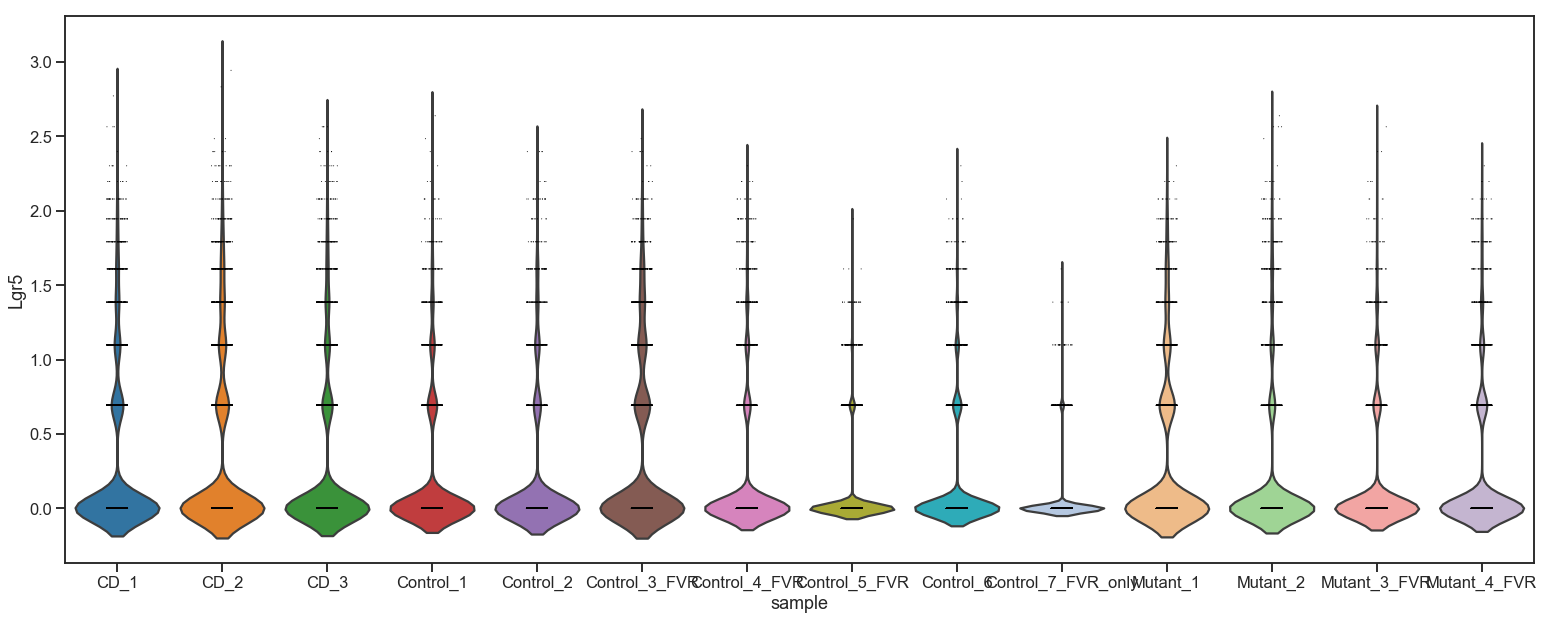

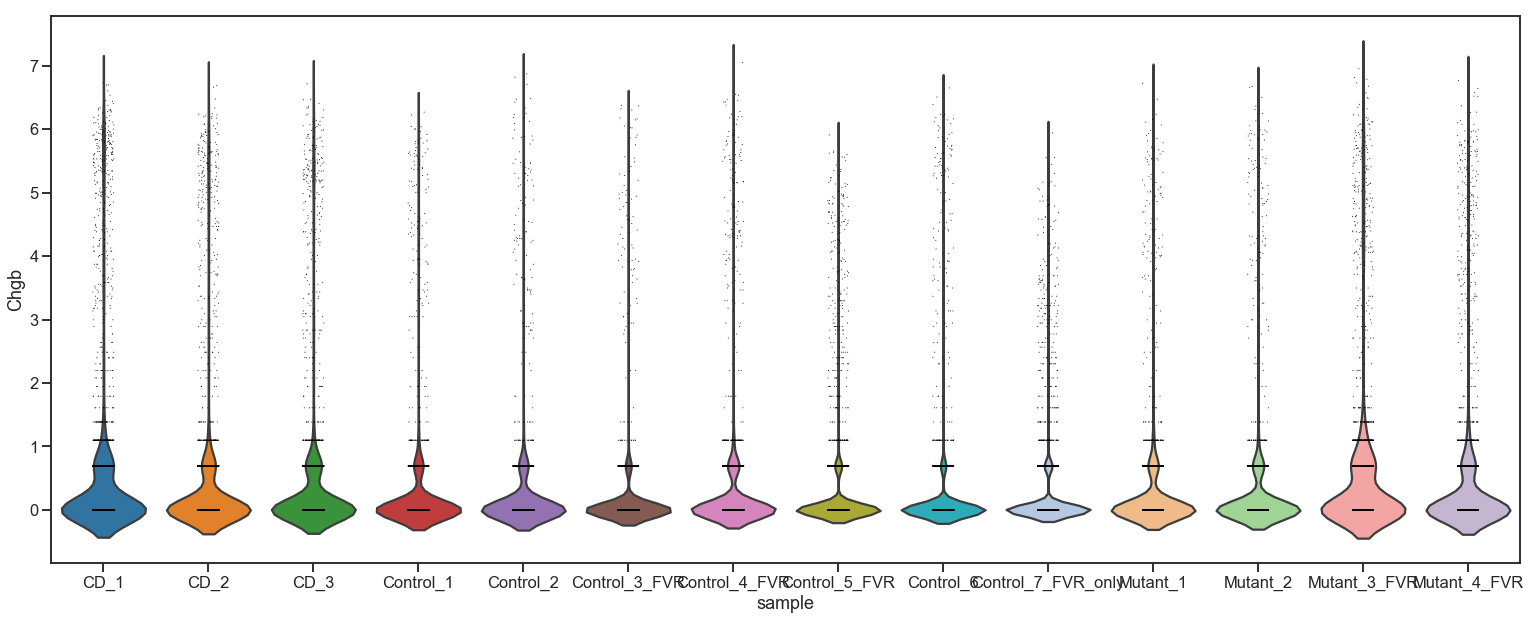

In [32]:
rcParams['figure.figsize']=(20,10)
sc.pl.violin(adata_all, keys='Lyz1', groupby='sample')
sc.pl.violin(adata_all, keys='Lgr5', groupby='sample')
sc.pl.violin(adata_all, keys='Chgb', groupby='sample')

# Remove doublets 

We have computed a doublet score on the raw count data for each sample using **Scrublet**. We will remove all cells with a doublet score *greater than 0.4*. The tool itself recommends to use a threshold of *0.25*, but we choose a more conservative strategy. 

In [34]:
(adata_all.obs['doublet_score']>=0.4).sum()

0

We will remove no cells from our data set based on the doublet score.

In [35]:
adata = adata_all[adata_all.obs['doublet_score']<0.4,:]

In [36]:
adata

View of AnnData object with n_obs × n_vars = 75012 × 14941 
    obs: 'sample', 'percent_mito', 'percent_ribo', 'n_counts', 'n_genes', 'batch', 'doublet_score', 'doublet'
    uns: 'pca', 'sample_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'

# Remove immune cells

In [2]:
adata = sc.read('./../data/gut_AB_AL_all.h5ad')

In [3]:
sc.tl.louvain(adata)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:04.45) --> found 22 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


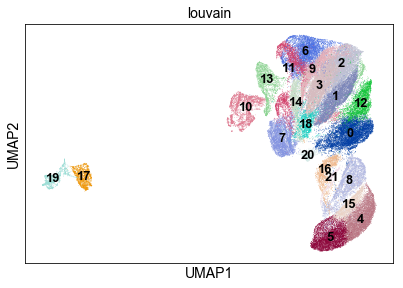

In [4]:
sc.pl.umap(adata, color='louvain', legend_loc='on data')

## Characterise gene expression

In [5]:
sc.tl.rank_genes_groups(adata, groupby='louvain')

ranking genes
    finished (0:03:07.10) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids


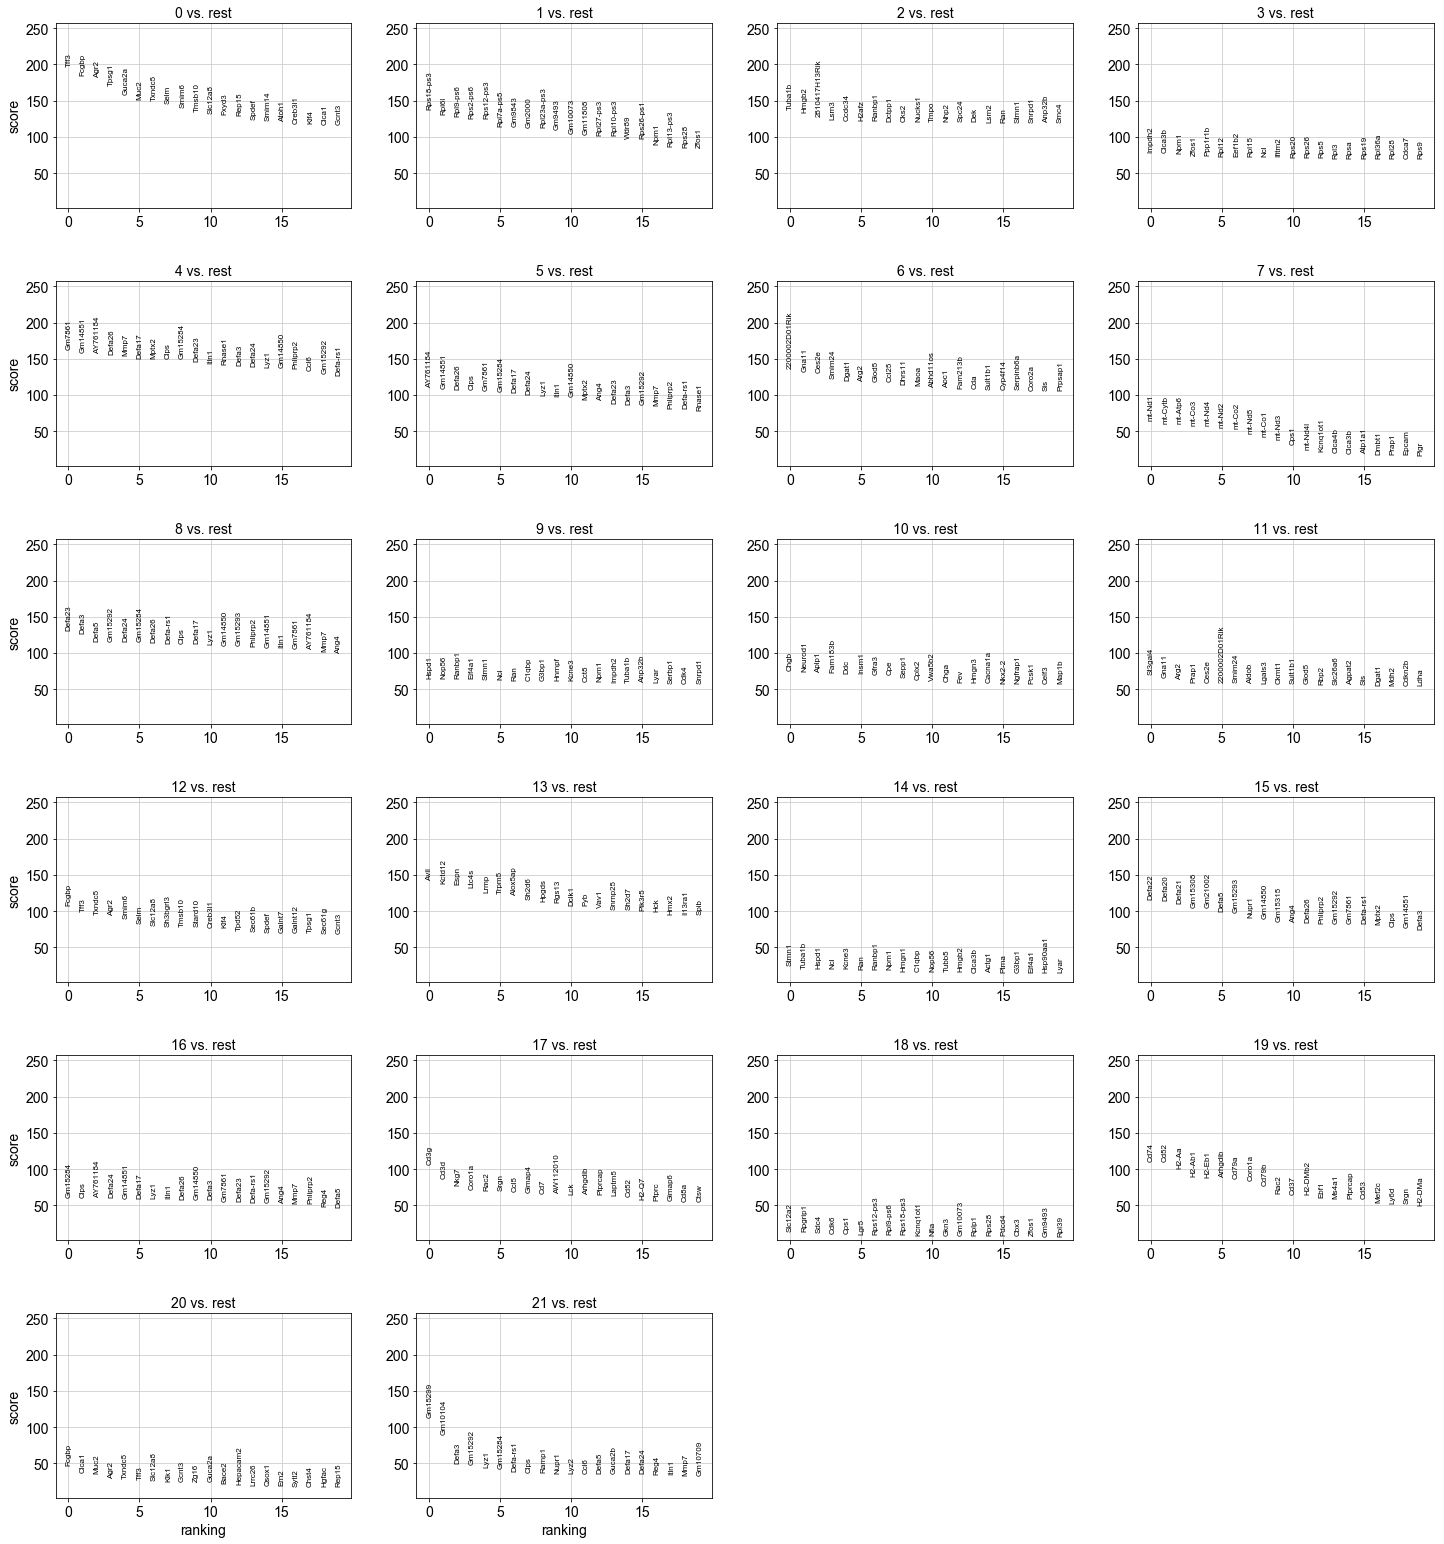

In [6]:
sc.pl.rank_genes_groups(adata)

Clusters 17 and 19 express immune cell signatures of T cells and B cells (Cd3g, Cd74). We exclude those cells.

In [7]:
adata = adata[np.invert(np.in1d(adata.obs['louvain'], ['17', '19']))]

In [8]:
adata

View of AnnData object with n_obs × n_vars = 72290 × 14941 
    obs: 'sample', 'percent_mito', 'percent_ribo', 'n_counts', 'n_genes', 'batch', 'doublet_score', 'doublet', 'louvain'
    uns: 'neighbors', 'pca', 'sample_colors', 'louvain', 'louvain_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'

## Recompute embedding

In [9]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:28.35) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:01:02.98) --> added
    'X_umap', UMAP coordinates (adata.obsm)


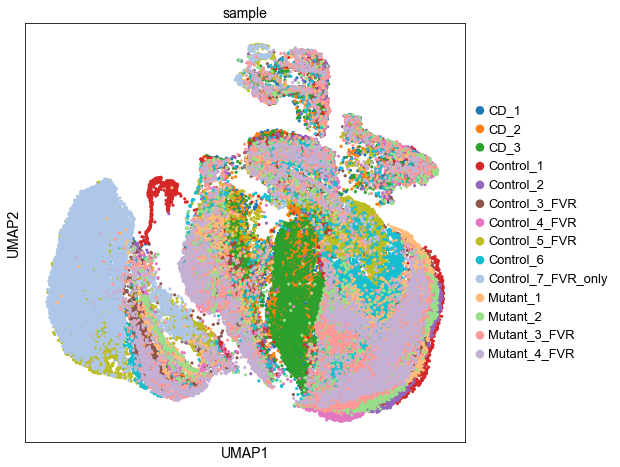

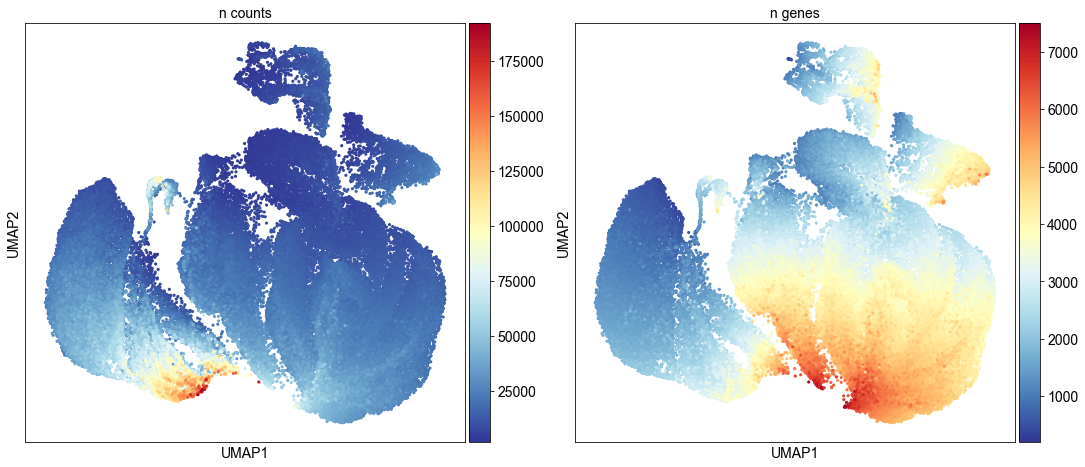

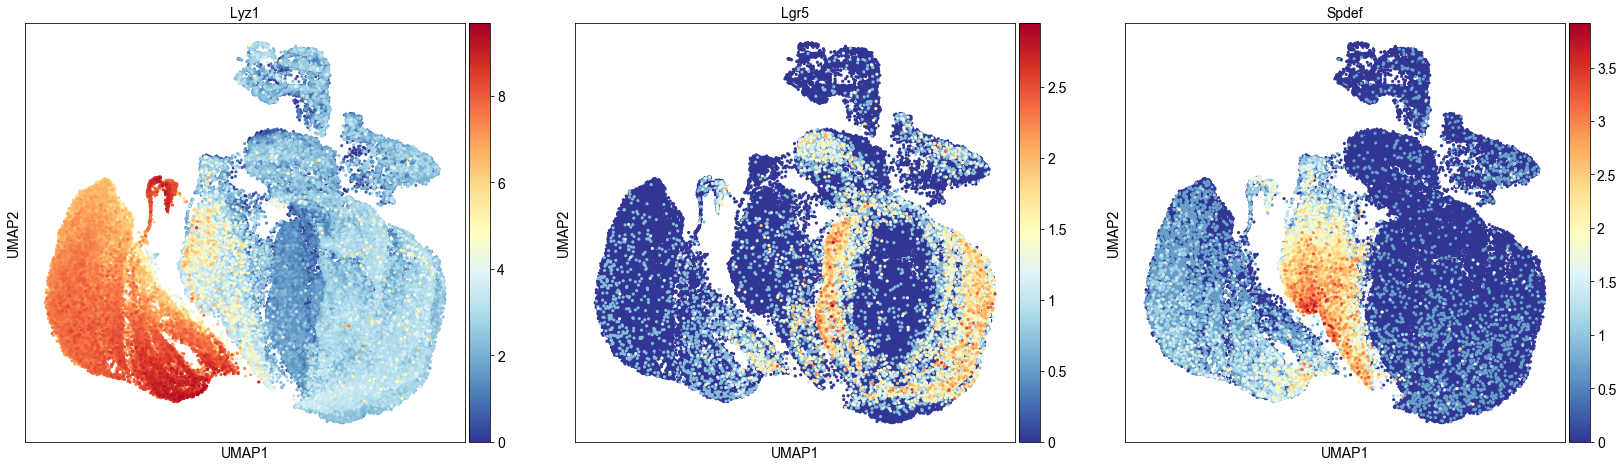

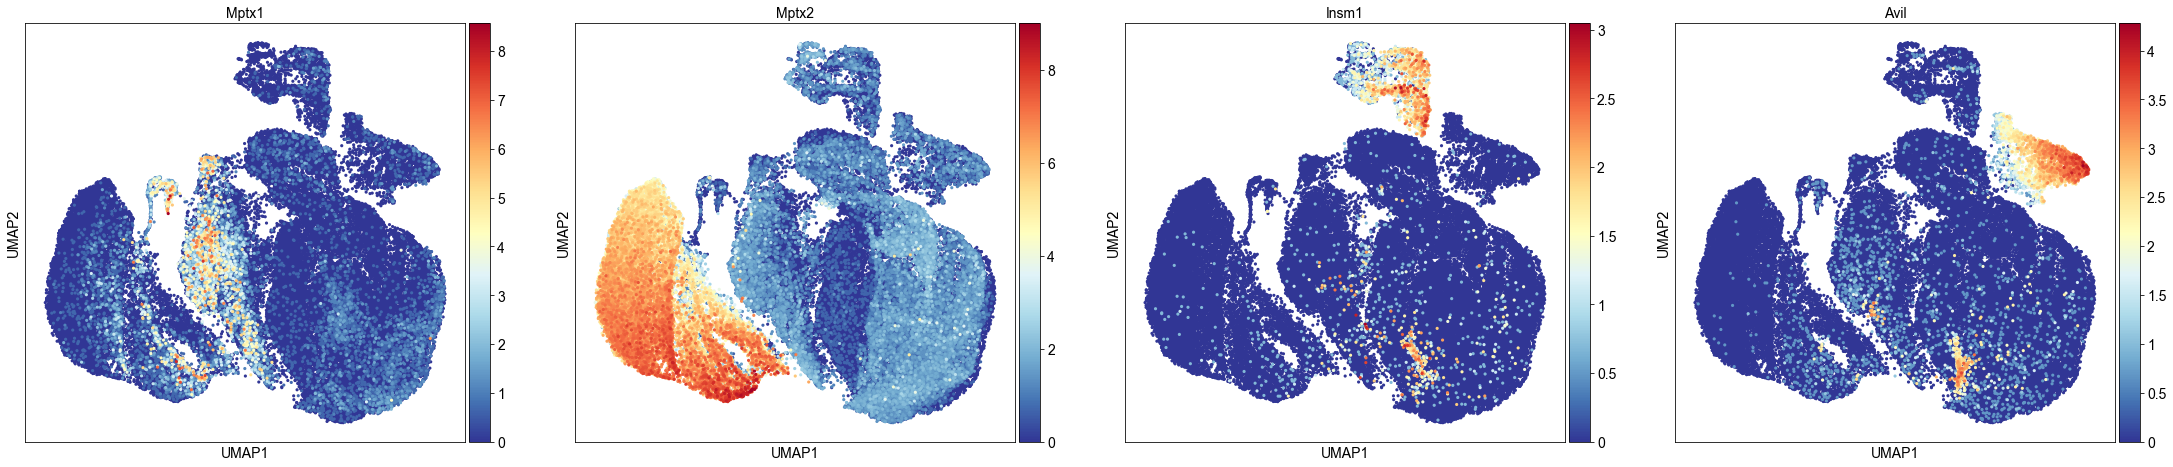

In [10]:
rcParams['figure.figsize']=(7,7)
sc.pl.umap(adata, color=['sample'], size=40)
sc.pl.umap(adata, color=['n_counts', 'n_genes'], size=40)
sc.pl.umap(adata, color=['Lyz1', 'Lgr5', 'Spdef'], size=40, color_map='RdYlBu_r')
sc.pl.umap(adata, color=['Mptx1', 'Mptx2', "Insm1", 'Avil'], size=40,color_map='RdYlBu_r')

In [12]:
sc.write(adata=adata, filename='./../data/gut_AB_AL_all.h5ad')

# Check the new data (Control_7_ FVR_only and Control_5_FVR)

We have observed an inssue with the ComBat batch effect correction especially with **Control_5_FVR** and **Control_7_FVR_only** data as it is dominated by Paneth cells. We want to adjust the ComBat model in such a way that we downsample the Paneth cells to ~ 15 % and then used the reduced data set for correction. In the end, by retrieving the correction variables, we will correct the rest of the cells, which we excluded initially.

In [15]:
pd.value_counts(adata.obs['sample'])

Control_5_FVR         8856
Control_7_FVR_only    8511
Control_6             7059
CD_2                  5232
CD_1                  5216
Control_4_FVR         5075
CD_3                  4988
Control_3_FVR         4391
Mutant_4_FVR          4390
Mutant_2              3932
Mutant_3_FVR          3857
Control_1             3828
Mutant_1              3819
Control_2             3136
Name: sample, dtype: int64

In [17]:
adata_sub = adata[np.in1d(adata.obs['sample'], ['Control_7_FVR_only', 'Control_5_FVR']),:]

In [18]:
adata_sub

View of AnnData object with n_obs × n_vars = 17367 × 14941 
    obs: 'sample', 'percent_mito', 'percent_ribo', 'n_counts', 'n_genes', 'batch', 'doublet_score', 'doublet', 'louvain'
    uns: 'neighbors', 'pca', 'sample_colors', 'louvain', 'louvain_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'

## Dimension reduction

In [19]:
sc.tl.pca(adata_sub)

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.


In [20]:
sc.pp.neighbors(adata_sub)
sc.tl.umap(adata_sub)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:06.48) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:13.27) --> added
    'X_umap', UMAP coordinates (adata.obsm)


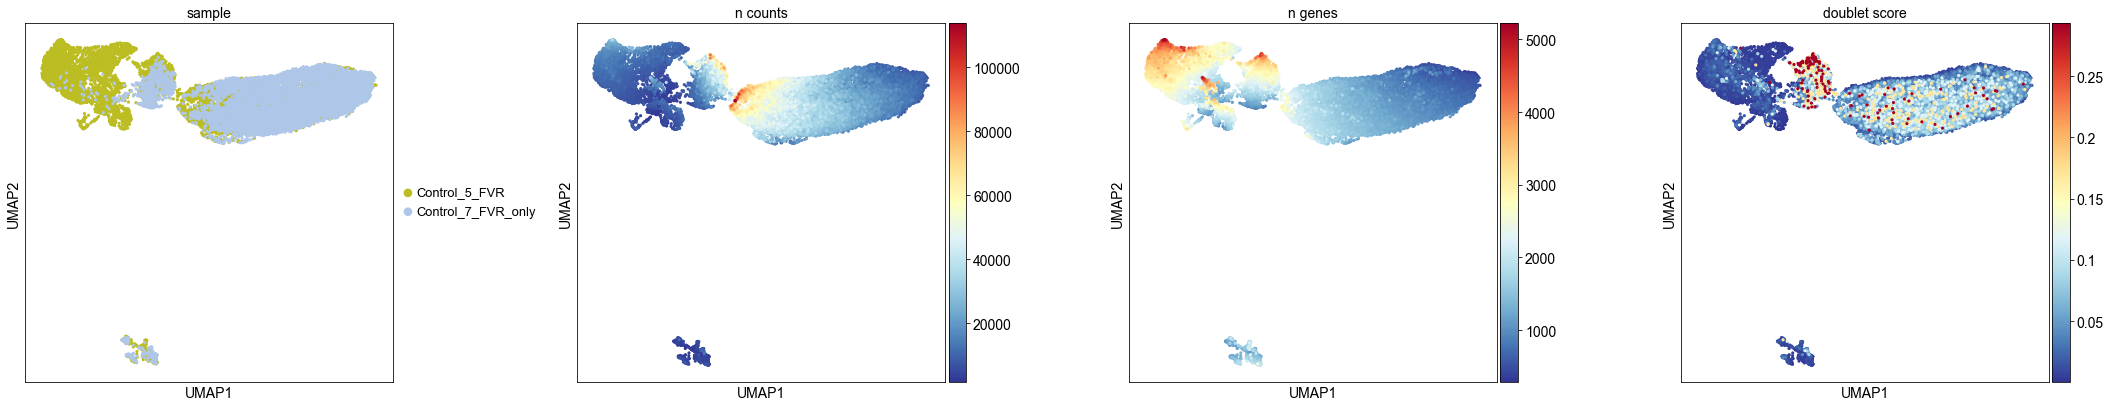

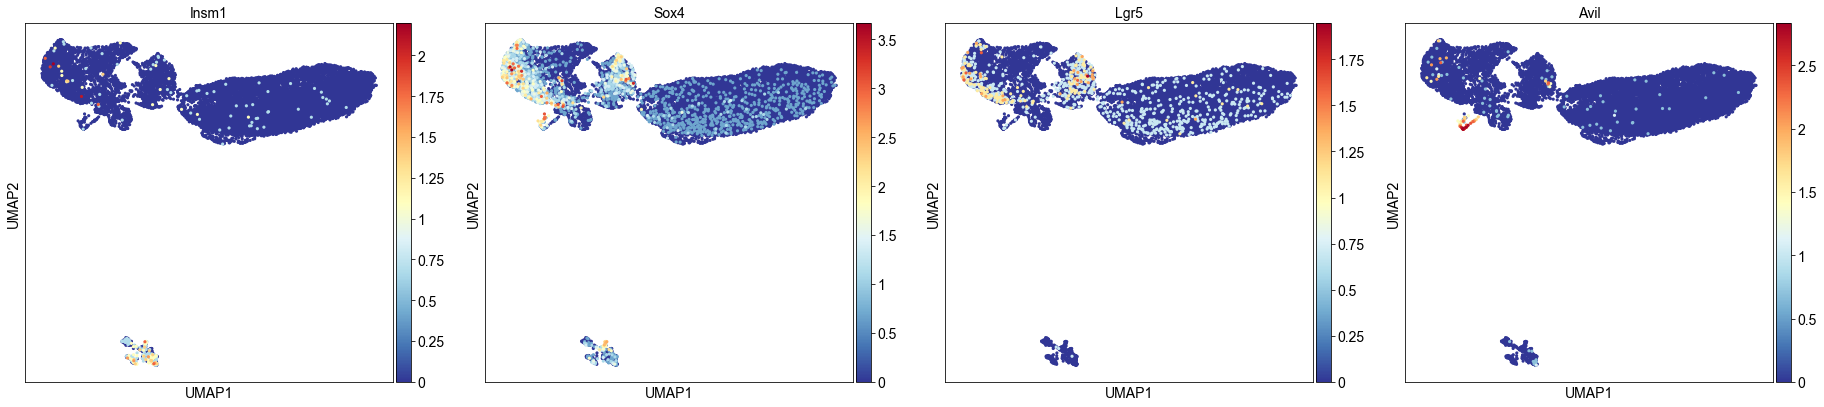

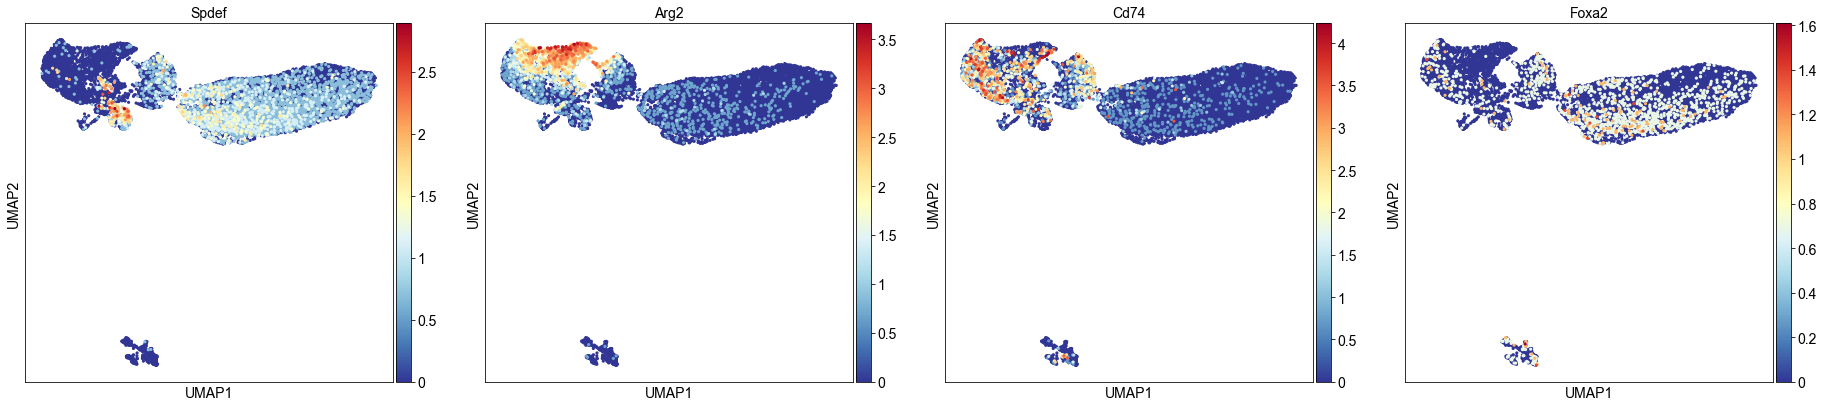

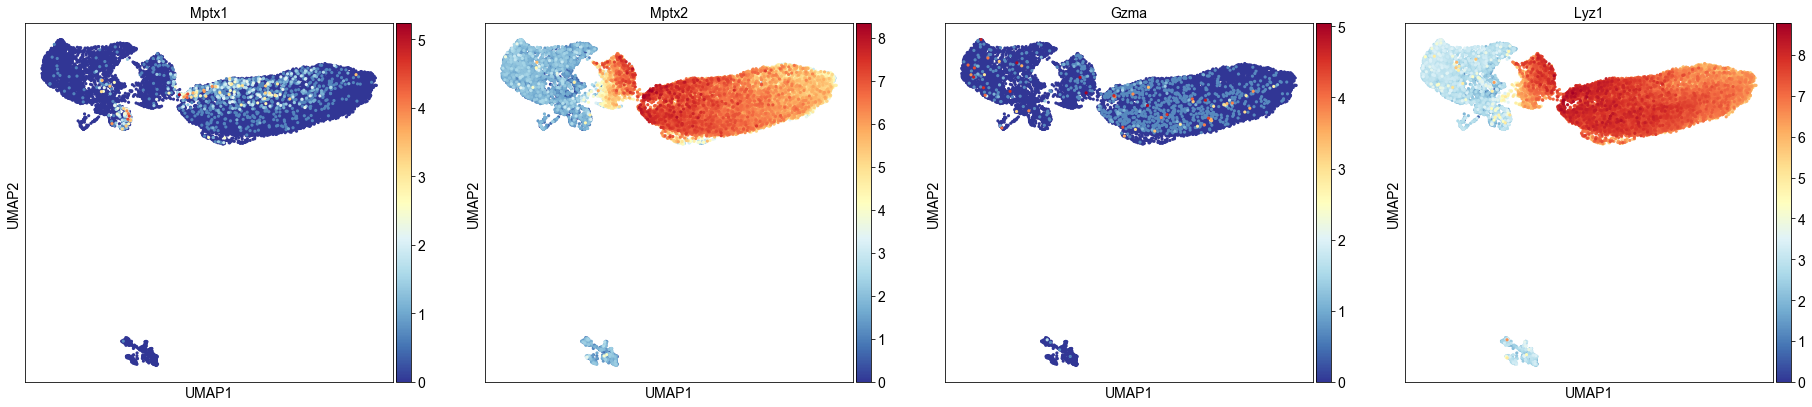

In [21]:
rcParams['figure.figsize']=(6,6)
sc.pl.umap(adata_sub, color=['sample', 'n_counts', 'n_genes', 'doublet_score'], size=40)
sc.pl.umap(adata_sub, color=['Insm1', 'Sox4', 'Lgr5', 'Avil'], size=40)
sc.pl.umap(adata_sub, color=['Spdef', 'Arg2', 'Cd74', 'Foxa2'], size=40)
sc.pl.umap(adata_sub, color=['Mptx1', 'Mptx2', 'Gzma','Lyz1'], size=40)

## Clustering

In [22]:
sc.tl.louvain(adata_sub, resolution=0.2)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.99) --> found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


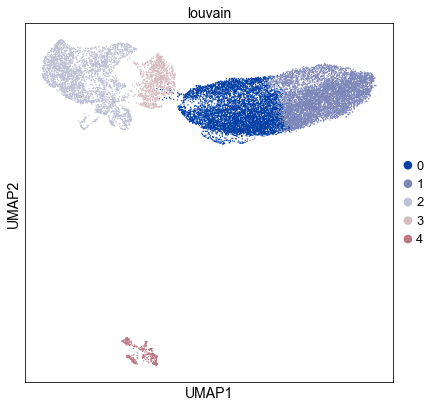

In [23]:
sc.pl.umap(adata_sub, color='louvain')

In [24]:
pd.value_counts(adata_sub.obs['louvain'])

0    6341
1    6061
2    3481
3    1094
4     390
Name: louvain, dtype: int64

In [25]:
pd.crosstab(adata_sub.obs['louvain'], adata_sub.obs['sample'], margins=True)

sample   Control_5_FVR  Control_7_FVR_only    All
louvain                                          
0                 3195                3146   6341
1                 1450                4611   6061
2                 3416                  65   3481
3                  587                 507   1094
4                  208                 182    390
All               8856                8511  17367

How many Lgr5+ cells do we have in the Lyz1+ clusters?

In [26]:
adata_sub.obs['Lgr5 pos']=(adata_sub.X[:,adata_sub.var_names =='Lgr5']>0).todense()

In [27]:
adata_sub.obs['Lyz1 pos']=(adata_sub.X[:,adata_sub.var_names =='Lyz1']>4).todense()

In [28]:
pd.crosstab(adata_sub.obs['Lgr5 pos'], adata_sub.obs['louvain'], normalize='columns', margins=True)

louvain          0         1         2         3         4       All
Lgr5 pos                                                            
False     0.958839  0.978221  0.901752  0.758684  0.992308  0.942304
True      0.041161  0.021779  0.098248  0.241316  0.007692  0.057696

In [50]:
pd.crosstab(adata_sub.obs['Lyz1 pos'], adata_sub.obs['louvain'], normalize='columns', margins=True)

louvain          0    1         2         3         4    5       All
Lyz1 pos                                                            
False     0.000124  0.0  0.986274  0.011586  0.986301  1.0  0.222254
True      0.999876  1.0  0.013726  0.988414  0.013699  0.0  0.777746

Cluster 3 is predominantly Lyz1+ (Paneth cell marker) and 25% of the cells are also Lgr5+ (ISC marker). 

## Downsampling the Paneth cells

In [29]:
pd.crosstab(adata_sub.obs['louvain'],adata_sub.obs['sample'], margins=True)

sample   Control_5_FVR  Control_7_FVR_only    All
louvain                                          
0                 3195                3146   6341
1                 1450                4611   6061
2                 3416                  65   3481
3                  587                 507   1094
4                  208                 182    390
All               8856                8511  17367

We aim to reduce the number of Paneth cells to 15%.

In [30]:
paneth_idx = np.in1d(adata_sub.obs['louvain'], ['0','1','3'])
a = np.flatnonzero(paneth_idx)

In [31]:
reduce_by = (len(a)-0.15*adata_sub.X.shape[0])/0.85
sample_size = len(a)- int(reduce_by)

In [32]:
rand_down = a[np.sort(np.random.choice(len(a), size= sample_size, replace=False))]

Compute index of cells we removed.

In [33]:
rand_out = a[np.invert(np.in1d(a, rand_down))]

Split data.

In [34]:
adata_out = adata_sub[rand_out,:].copy()

In [35]:
keep_rest = np.invert(np.in1d(adata.obs_names,adata_sub.obs_names[rand_out]))

In [36]:
adata_merge = adata[keep_rest,:].copy()

In [37]:
adata_merge

AnnData object with n_obs × n_vars = 59478 × 14941 
    obs: 'sample', 'percent_mito', 'percent_ribo', 'n_counts', 'n_genes', 'batch', 'doublet_score', 'doublet', 'louvain'
    uns: 'neighbors', 'pca', 'sample_colors', 'louvain', 'louvain_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'

In [38]:
pd.value_counts(adata_merge.obs['sample'])

Control_6             7059
CD_2                  5232
CD_1                  5216
Control_4_FVR         5075
CD_3                  4988
Control_3_FVR         4391
Mutant_4_FVR          4390
Mutant_2              3932
Control_5_FVR         3899
Mutant_3_FVR          3857
Control_1             3828
Mutant_1              3819
Control_2             3136
Control_7_FVR_only     656
Name: sample, dtype: int64

In [39]:
sc.write('./../data/downsampled_data_AB_AL_n.h5', adata_merge)
sc.write('./../data/downsampled_out_data_AB_AL_n.h5', adata_out)